# I: Web Scraping

In [186]:
import requests
import urllib
from bs4 import BeautifulSoup
import simplejson as json
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import time
import re
import pandas as pd
import json
import datetime
import numpy as np
import unicodedata
from collections import Counter
from nltk import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import pickle
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
import os
import string
import copy
from   collections import defaultdict
from   nltk.corpus import stopwords
from   sklearn.feature_selection import SelectKBest, mutual_info_regression
from wordcloud import WordCloud 
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_validate
import pyLDAvis
import pyLDAvis.sklearn
import warnings
import pyLDAvis.gensim_models as gensimvis
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind

In [2]:
# define the base url needed to create the file url.
base_url = r"https://www.sec.gov"
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36'
}

# four-digit year pattern
yearPattern = re.compile(r'\d{4}$')

In [3]:
list_cik = pd.read_csv('nasdaq100_ticker_cik_mapping.csv').fillna(value = 0)
len(list_cik)

102

In [4]:
list_cik.head()

,symbol,company,cik,market_cap_05132022,last_sale_05132022,sector
0,AZN,AstraZeneca PLC American Depositary Shares,901832,1.957440e+11,63.17,Health Care
1,ADBE,Adobe Inc. Common Stock,796343,1.909140e+11,404.05,Information Technology
2,ODFL,"Old Dominion Freight Line, Inc. Common Stock",878927,3.133551e+10,276.44,Industrials
3,LCID,"Lucid Group, Inc. Common Stock",1811210,3.027965e+10,18.16,Consumer Discretionary
4,CEG,Constellation Energy Corporation Common Stock,1868275,1.802205e+10,55.17,Utilities


## 1. Scraping the SEC Query Page

In [5]:
# define lists to store the data scraped from the SEC website
ciks = []
risks = []
years = []
urls = []
companies = []
symbols = []
sectors = []

# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

In [6]:
driver = webdriver.Firefox()

### 1a. Helper functions 

In [7]:
# get the links to the 10k reports 
def get10kPages(url):
    response = requests.get(url = url, headers=header)
    soup10k = BeautifulSoup(response.content, 'html.parser')
    # print(response)
    # print(response.url)
    return response.url

In [8]:
def get10kLinks(url, list_of_10ks):
    response = requests.get(url = url, headers=header)
    soup = BeautifulSoup(response.content, 'html.parser')
    # for a in soup.find_all('a', href=True):
        # url = a['href']
        # print(url)
        
    suffix = "htm";

    tables = soup.find('table')
    rows = tables.find_all('tr')
    if len(rows) > 0:
        row10k = rows[1] # row 1 has link to 10k report
        # print(row10k)
        for a in row10k.find_all('a', href=True):
            url = a['href']
            if url.endswith(suffix):
                list_of_10ks.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)

In [9]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [10]:
# create a function that will scrap the 10k report 
def scrap10k(url, cik, company, symbol, sector):
    driver.get(url)

    time.sleep(2) # give browser some time to load the js 

    html = driver.page_source
    sp = BeautifulSoup(html)
    
    text = ""
    for d in sp.find_all(text=True):
        text += d.get_text()
    
    # cleaning 
    text = text.replace(u'\xa0', u' ').lower()
                
    # extract risk factor sections only

    # get fiscal year     
    yr = ""
    for span in sp.find_all(text=True):
        stext = span.text
        if (stext.find("January") != -1
         or stext.find("February") != -1
         or stext.find("March") != -1
         or stext.find("April") != -1
         or stext.find("May") != -1
         or stext.find("June") != -1
         or stext.find("July") != -1
         or stext.find("August") != -1
         or stext.find("September") != -1
         or stext.find("October") != -1
         or stext.find("November") != -1
         or stext.find("December") != -1):
            stext = stext.strip()
            yr = stext[-4:]
            break
            
    # proceed only when a valid year is scraped 
    yr_match = re.match(yearPattern, yr)
    if yr_match != None:
        yr = int(yr) # convert string to int
        if yr > 2006:
            start = find_nth(text, "item 1a.", 2)
            # print("start index", start)
            end = find_nth(text, "item 1b.", 2)
            # print("end index", end)
            substring = text[start:end]
            if len(substring) > 100: # only pull longer risk factors 
                risks.append(substring)
                years.append(yr)
                ciks.append(cik)
                urls.append(url)
                companies.append(company)
                symbols.append(symbol)
                sectors.append(sector)

In [11]:
def getDataByCIK(cik, company, symbol, sector):
    ########################################
    ### Step 1. Scraping the SEC Query Page
    ########################################
    # define our parameters dictionary
    param_dict = {'action':'getcompany',
                  'CIK': cik,
                  'type':'10-k',
                  'dateb':'20230101',
                  'owner':'exclude',
                  'start':'',
                  'output':'',
                  'count':'100'}

    # request the url, and then parse the response.
    response = requests.get(url = endpoint, params = param_dict, headers=header)
    # response = requests.get(url = endpoint, params = param_dict)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    doc_table = soup.find_all(class_ = "blueRow")
    
    data = soup.find_all(class_='blueRow')

    list_10k = []

    for i, row in enumerate(data): 
        for a in data[i].find_all('a', href=True):
            url = a['href']
            if (url.startswith('/Archives/edgar/')):
                list_10k.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)
                
    ########################################
    ### Step 2. Scraping Company Page 
    ########################################
    
    list_of_links = []
    for link in list_10k:
        list_of_links.append(get10kPages(link))
        
    # get the url for 10k report 
    list_of_10ks = []
    for url in list_of_links:
        get10kLinks(url, list_of_10ks)
        

    ########################################
    ### Step 3. Scraping 10k Reports 
    ########################################
    for report in list_of_10ks:
        scrap10k(report, cik, company, symbol, sector)

### 1b. Run scripts for all the companies of interest

In [14]:
%%time
for i, row in list_cik.iterrows():
    getDataByCIK(row.cik, row.company, row.symbol, row.sector)

CPU times: user 17min 42s, sys: 37.3 s, total: 18min 20s
Wall time: 1h 2min 18s


### 1c. Create Data Frame

In [15]:
# create a data frame
data_tuples = list(zip(ciks, symbols, companies, years, risks, sectors, urls))
# data_tuples

df = pd.DataFrame(data_tuples, columns=['cik', 'symbol', 'company', 'fiscal_year', 'risk', 'sector', 'url'])

In [16]:
df.head()

,cik,symbol,company,fiscal_year,risk,sector,url
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...


In [17]:
len(df)

325

## 2. Scrap stock prices from Yahoo Finance 

In [18]:
dict_fi = {}

In [19]:
def getStockPricesByTicker(ticker, fiscal_year, period1, period2):
    url_history = f'https://finance.yahoo.com/quote/{ticker}/history?period1={period1}&period2={period2}&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=false'
    
    respf = requests.get(url_history, headers=header)
    # print(respf)
    
    soupf = BeautifulSoup(respf.text, 'html.parser')
    
    patternf = re.compile(r'\s--\sData\s--\s')
    script_data = soupf.find('script', text=patternf).contents[0]
    
    start = script_data.find("context")-2
    json_data = json.loads(script_data[start:-12])
    
    # get historical stock prices 
    try:
        HistoricalPriceStore = json_data['context']['dispatcher']['stores']['HistoricalPriceStore']
        # print(HistoricalPriceStore)
        # clean the stock price data 
        close = -99999 #default
        for row in HistoricalPriceStore['prices']:
            date = row['date']
            dt_formatted = datetime.datetime.fromtimestamp(date).date() # using the local timezone

            # get the stock price in December of a given year 
            if dt_formatted.month == 12 and dt_formatted.year == fiscal_year and 'close' in row:
                # debug
                # print(ticker, "=========", fiscal_year, "=====", row['date'])
                # print(HistoricalPriceStore)
                close = row['close']
                break # once find a December record then stop looking

        if dict_fi.get(ticker) == None:
            dict_fi[ticker] = {}

        dict_fi[ticker][fiscal_year] = close
    except:
        return None

### 2b. Run scripts for all the records collected from #1

In [20]:
%%time
for i, row in df.iterrows():
    ticker = row.symbol
    fiscal_year = row.fiscal_year
    # period1 = '1167609600' # 2007-01-01
    # period2 = '1672444800' # 2022-12-30
    getStockPricesByTicker(ticker, fiscal_year, '1167609600', '1672444800')

CPU times: user 47.4 s, sys: 2.54 s, total: 50 s
Wall time: 11min 24s


### 2c. Create data frames for stock prices

In [21]:
len(dict_fi)

72

In [22]:
df_fi = pd.DataFrame.from_records(
    [
        (level1, level2, leaf)
        for level1, level2_dict in dict_fi.items()
        for level2, leaf in level2_dict.items()
    ],
    columns=['symbol', 'fiscal_year', 'price']
)

In [23]:
df_fi.head()

,symbol,fiscal_year,price
0,ADBE,2018,226.240005
1,ADBE,2016,102.949997
2,ADBE,2014,72.699997
3,ADBE,2012,37.680000
4,ADBE,2010,30.780001


### 2d. Merge two data frames

In [24]:
merged_df = pd.merge(df, df_fi, how='left', on=['fiscal_year','symbol'])

In [25]:
merged_df

,cik,symbol,company,fiscal_year,risk,sector,url,price
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,226.240005
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,102.949997
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,72.699997
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,37.680000
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,30.780001
...,...,...,...,...,...,...,...,...
320,900075,CPRT,"Copart, Inc. (DE) Common Stock",2016,item 1a. risk factorsinvesting in our commo...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,27.705000
321,900075,CPRT,"Copart, Inc. (DE) Common Stock",2014,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.245001
322,900075,CPRT,"Copart, Inc. (DE) Common Stock",2013,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.325001
323,900075,CPRT,"Copart, Inc. (DE) Common Stock",2010,item 1a. risk factors \n investing ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,9.337500


# II: Data Cleaning & Exploratory Analysis

### 0. Helper functions

In [26]:
def word_count(text):
    counter = Counter()
    tokens_nltk = word_tokenize(text)

    for token in tokens_nltk:
        counter[token] += 1
    return sum(counter.values())

### 1. Exclude invalid stock prices 

In [27]:
merged_df = merged_df[merged_df['price'] >= 0]

### 2. Clean the text

In [28]:
text_list = []
text_len = []
for text in merged_df['risk']:
    text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())
    text_list.append(text)
    cnt = word_count(text)
    text_len.append(cnt)

<>:4: DeprecationWarning: invalid escape sequence \ 
<>:4: DeprecationWarning: invalid escape sequence \ 
/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_35344/3134892021.py:4: DeprecationWarning: invalid escape sequence \ 
  text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())


### 3. Add more metadata

In [29]:
# add the cleaned text as a column to the df
merged_df['text'] = text_list

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_35344/237560845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'] = text_list


In [30]:
merged_df['word_count'] = text_len

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_35344/945730304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['word_count'] = text_len


In [31]:
merged_df.describe()

,cik,fiscal_year,price,word_count
count,3.240000e+02,324.000000,324.000000,324.000000
mean,8.967057e+05,2013.320988,93.261426,21207.962963
std,3.842232e+05,3.542147,192.085350,18653.122804
min,2.488000e+03,2007.000000,1.630000,1423.000000
25%,7.738400e+05,2010.000000,25.190000,8537.750000
50%,8.981730e+05,2014.000000,47.769999,13693.500000
75%,1.093557e+06,2016.000000,84.357498,28485.000000
max,1.811210e+06,2020.000000,1722.420044,114960.000000


In [32]:
merged_df.head()

,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,226.240005,"item 1a. risk factorsas previously discussed,...",10522
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,102.949997,"item 1a. risk factorsas previously discussed,...",10538
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,72.699997,"item 1a. risk factorsas previously discussed,...",10297
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,37.680000,"item 1a. risk factorsas previously discussed,...",9580
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,30.780001,item 1a. risk factors as previously discuss...,8793


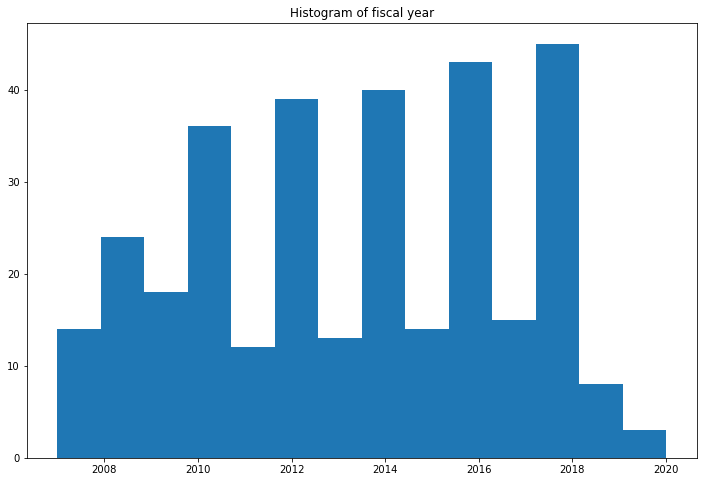

In [33]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.fiscal_year, bins=merged_df.fiscal_year.nunique())
plt.title("Histogram of fiscal year")
plt.show()

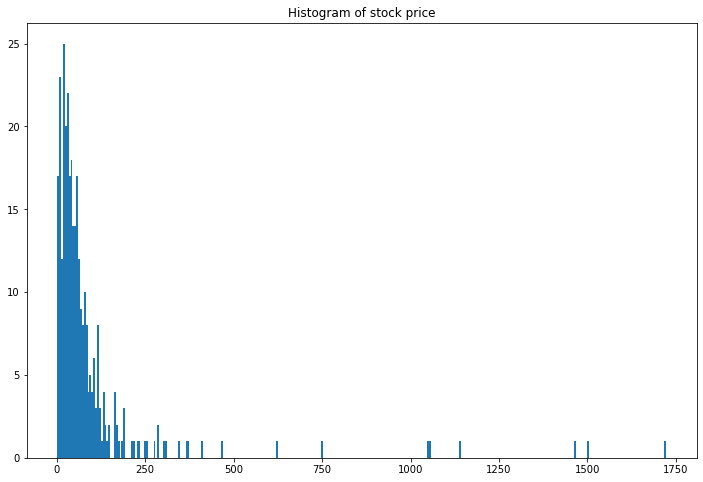

In [34]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.price, bins=merged_df.price.nunique())
plt.title("Histogram of stock price")
plt.show()

#### It seemed most of the stock prices fall into <= USD 250 bucket. 

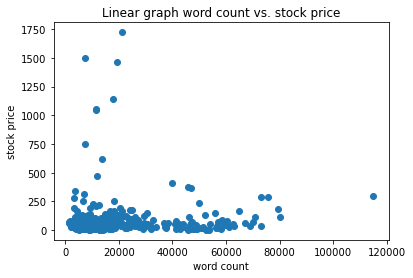

In [35]:
# depicting the visualization
plt.scatter(merged_df.word_count, merged_df.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

#### From the graph above, we couldn't find any obvious correlation between word count and stock prices. 

#### I pulled the companies with stock prices above USD 750 for sanity check. It seemed they were accurate. 

In [36]:
merged_df[merged_df.price > 750]

,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
23,1652044,GOOG,Alphabet Inc. Class C Capital Stock,2017,item 1a.risk factorsour operations and financi...,Communication Services,https://www.sec.gov/Archives/edgar/data/165204...,1046.400024,item 1a.risk factorsour operations and financi...,11405
24,1652044,GOOGL,Alphabet Inc. Class A Common Stock,2017,item 1a.risk factorsour operations and financi...,Communication Services,https://www.sec.gov/Archives/edgar/data/165204...,1053.400024,item 1a.risk factorsour operations and financi...,11405
109,1018724,AMZN,"Amazon.com, Inc. Common Stock",2018,item 1a.risk factorsplease carefully consider ...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/101872...,1501.969971,item 1a.risk factorsplease carefully consider ...,7367
269,1075531,BKNG,Booking Holdings Inc. Common Stock,2018,item 1a. risk factors the following risk fact...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/107553...,1722.420044,item 1a. risk factors the following risk fact...,21340
270,1075531,BKNG,Booking Holdings Inc. Common Stock,2016,item 1a. risk factors the following risk fact...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/107553...,1466.060059,item 1a. risk factors the following risk fact...,19489
271,1075531,BKNG,Booking Holdings Inc. Common Stock,2014,item 1a. risk factors the following risk fac...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/107553...,1140.209961,item 1a. risk factors the following risk fac...,17825


#### Next, I removed the duplicates in the data frame based on cik and fiscal_year, and removed outliers with stock prices greater than USD 250. 

In [37]:
data = merged_df.drop_duplicates(subset=['cik', 'fiscal_year'])

In [38]:
data = data[data.price <= 250]

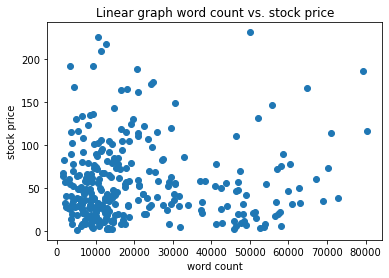

In [39]:
# depicting the visualization after dropping duplicates and outliners 
plt.scatter(data.word_count, data.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

#### From this graph, it can be hard to find a correlation between word count and stock price. 

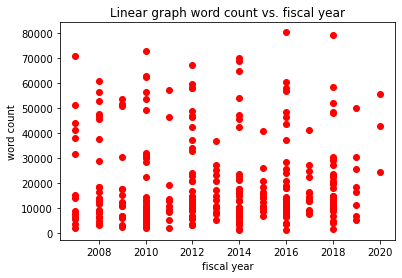

In [40]:
# depicting the visualization
plt.scatter(data.fiscal_year, data.word_count, color="red") 
plt.xlabel('fiscal year') 
plt.ylabel('word count') 
plt.title("Linear graph word count vs. fiscal year")
plt.show() 

#### From the graph above, we couldn't find obvious trend of either decreasing or increasing word count in the risk factor sections in the 10-K reports as time goes by. 

### 4. Generate a word cloud based on all the risk text

In [41]:
#convert list to string and generate
all_risks=(" ").join(data.risk)

In [42]:
print(word_count(all_risks))

6314098


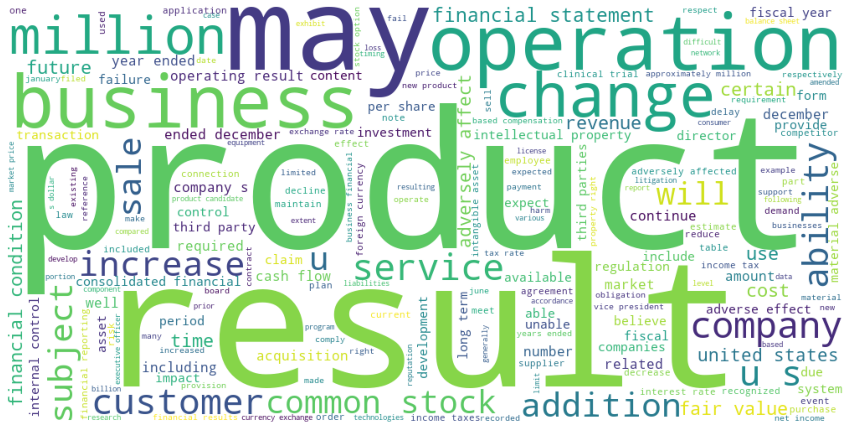

In [43]:
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(all_risks)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

* First of all, The word cloud graph showed us that companies most frequently mentioned **product** and **result** in their *Risk Factors* sections in the 10-K reports, which might indicate that they were result-driven business and concentrated on the risks during the development of products -- the core competency of their businesses. 

* Second, **operation**, **change**, **business**, **customer**, **service**, were cued quite a bit across all the 10-K reports in our dataset. While *changes* can be good things, they could also bring in new challenges for business. Meanwhile, *sales*, *customers* and *services* would also greatly impact the financial health of a company, which were mentioned very often. 

* Lastly, we could also spot plenty money related words when companies discussed their risk factors, such as **cash flow**, **financial condition**, **cost**, **revenue**. Other things they were concerned about included **third party**, **intellectual property**, and so on. 

### 5. Save the cleaned data frame

In [44]:
data.to_csv("data.csv", encoding='utf-8', sep=',', header='true')